<a href="https://colab.research.google.com/github/drAshcroft/MAT422/blob/main/HW37_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
#import pytorch to do the heavy lifting of optimized linear algebra and backpropogation
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

First we load the dataset and create a test/train split to allow accuracy tests.

In [4]:
# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Create a data loader for the training data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create a data loader for the test data
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


The dataset consists of handwritten digits and their classification

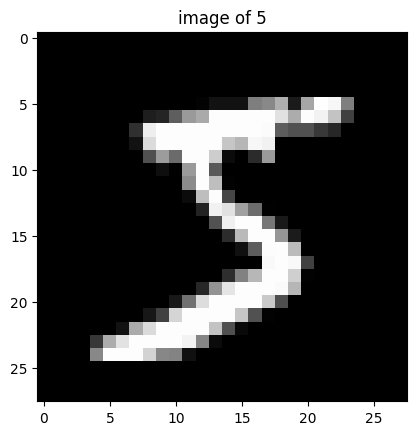

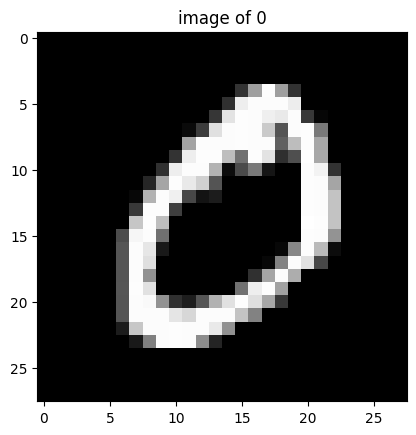

In [12]:
# Display the image
plt.title(f'image of {train_dataset[0][1]}')
plt.imshow(train_dataset[0][0][0], cmap='gray')
plt.show()

# Display the image
plt.title(f'image of {train_dataset[1][1]}')
plt.imshow(train_dataset[1][0][0], cmap='gray')
plt.show()

Now we create a simple model to identify the handwritten digits.

In [14]:

model = nn.Sequential(
    nn.Flatten(),  #flatten 2D image to 1D vector
    nn.Linear(784, 100),  #multiple 1D vector by transformation matrix to assign weights to each vector component
    nn.ReLU(), #apply an activation function that identifies only the positive sums after inner product
    nn.Linear(100, 10) #perform a second inner product to assign likelyhoods to 1 of 10 classes (digits)
)

In [15]:
criterion = nn.CrossEntropyLoss()  #define a loss function to determine how accurate the last guess was for the nonlinear fitting.
optimizer = optim.Adam(model.parameters() )  #an advanced newton solver for determining the solution and actively changing the step size of the fitter

Now that the model is defined and a 'brain' created with the possibility of learning, we seek a solution that can identify the digits.

In [21]:
for epoch in range(10): #loop through the data at least 10 times (epochs)
    for batch, (inputs, labels) in enumerate(train_loader):  #loader will get data in batch size identified above
        optimizer.zero_grad()  #the optimizer only knows when the step starts with this function.  Clear old information and get
        #information about current pass and data
        predict = model(inputs)  #perform all the inner products and apply activation functions.
        loss = criterion(predict, labels)# Calculate the loss


        loss.backward()  # now that the loss is identified propogate this information backwards through the matrix using the derivatives of each step to inform the change in each step
        optimizer.step()  # perform the step by changing the weights of the matrix
        print('.',end='')  #update the user that training is taking place
        if (batch % 75)==0:
          print(f'{loss.item():.2f}')



.0.01
...........................................................................0.08
...........................................................................0.01
...........................................................................0.01
...........................................................................0.00
...........................................................................0.00
...........................................................................0.12
...........................................................................0.00
...........................................................................0.08
...........................................................................0.10
...........................................................................0.00
...........................................................................0.00
...........................................................................0.15
..................................

We can now identify how accurate the model was by testing against a different dataset.  This will show how general the solution was.

We use the confusion matrix to visually check the results.

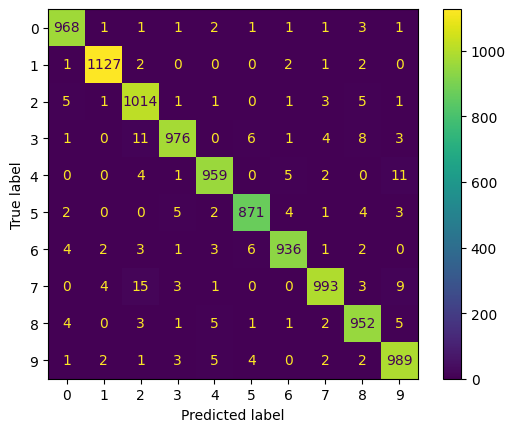

In [27]:

targets =[]
predictions = []
#model.eval()  #notify pytorch that we wish to evaluate the model now instead of training
with torch.no_grad():#do not keep track of derivative at each step to allow smaller memory footprints
    for batch, (inputs, labels) in enumerate(test_loader):
        predict = model(inputs) #perform all the inner products and apply activation functions.
        highest = torch.argmax(predict, dim=1)
        targets.extend(labels.tolist())
        predictions.extend(highest.tolist())

classes = list(set(targets))
classes.sort()
cm = confusion_matrix(targets, predictions, labels=classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()


The handwritting dataset shows the power of a simple model, but is limited for real world examples.  We will now look at a model that requires more power in the form of 2D convolutions combined with neural networks.  These are called CNNs.

We will follow a simple example of a linear neural network to classify images in a publically availble imageset.  In this case, we will be looking at images from the fashion MNIST and trying to find the ones that have skirts

In [28]:
#load the fashion dataset from the toy dataset repository
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Create a test train dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 26421880/26421880 [00:01<00:00, 13446744.30it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 195117.58it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3694753.44it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16395047.07it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



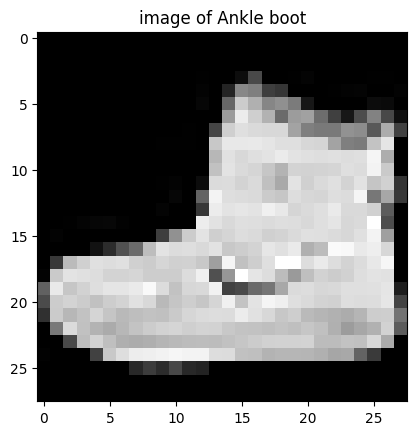

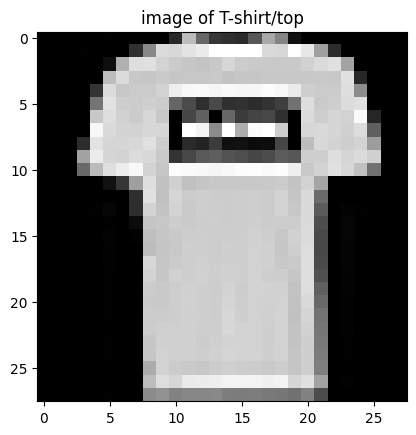

In [30]:
classMeanings =['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

# Display the image
plt.title(f'image of {classMeanings[train_dataset[0][1]]}')
plt.imshow(train_dataset[0][0][0], cmap='gray')
plt.show()

# Display the image
plt.title(f'image of {classMeanings[train_dataset[1][1]]}')
plt.imshow(train_dataset[1][0][0], cmap='gray')
plt.show()

Create a model using 2D convolutions to better deal with image data and its complixity.  The main trade off is that the new steps add complexity to the model, resulting in more difficut training and higher likelyhood of overfitting.

In [31]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  #create a model that converts a 1 color image into a smaller 32 color image with unknown meaning to the 32 colors
    nn.ReLU(), #activation function to only allow positive values
    nn.MaxPool2d(kernel_size=2, stride=2), #reduce a 2x2 neighborhood by the highest nearby values
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), #get information about the 2D neighbor hood again
    nn.ReLU(), #activation function to only allow positive values
    nn.MaxPool2d(kernel_size=2, stride=2),#reduce a 2x2 neighborhood by the highest nearby values
    nn.Flatten(), #convert the new information down to a flat vector for classification
    nn.Linear(64 * 7 * 7, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)


In [33]:
# Define a loss function and a solver as we did above.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

cc=0
for epoch in range(10):
    for batch_idx, (inputs, target) in enumerate(train_loader):

        optimizer.zero_grad() #the optimizer only knows when the step starts with this function.  Clear old information and get
        #information about current pass and data

        outputs = model(inputs) #perform all the inner products and apply activation functions.

        loss = criterion(outputs, target) # Calculate the loss
        loss.backward() # now that the loss is identified propogate this information backwards through the matrix using the derivatives of each step to inform the change in each step

        optimizer.step()        # perform the step by changing the weights of the matrix
        print('.',end='')  #update the user that training is taking place
        if (cc % 75)==0:
          print(f'{loss.item():.2f}')
        cc+=1



.0.40
...........................................................................0.32
...........................................................................0.33
...........................................................................0.16
...........................................................................0.21
...........................................................................0.33
...........................................................................0.15
...........................................................................0.48
...........................................................................0.33
...........................................................................0.09
...........................................................................0.19
...........................................................................0.17
...........................................................................0.26
..................................

We can now identify how accurate the model was by testing against a different dataset.  This will show how general the solution was.

We use the confusion matrix to visually check the results.

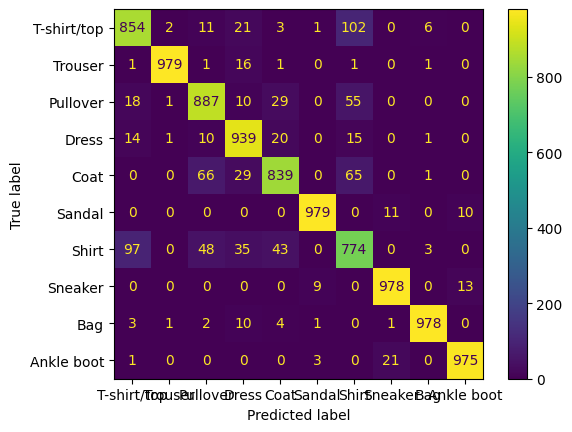

In [35]:

targets =[]
predictions = []
#model.eval()  #notify pytorch that we wish to evaluate the model now instead of training
with torch.no_grad():#do not keep track of derivative at each step to allow smaller memory footprints
    for batch, (inputs, labels) in enumerate(test_loader):
        predict = model(inputs) #perform all the inner products and apply activation functions.
        highest = torch.argmax(predict, dim=1)
        targets.extend(labels.tolist())
        predictions.extend(highest.tolist())

classes = list(set(targets))
classes.sort()
cm = confusion_matrix(targets, predictions, labels=classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classMeanings)
disp.plot()
plt.show()



In [36]:
from sklearn.metrics import accuracy_score

accuracy_score(targets, predictions)


0.9182